In [1]:
# %matplotlib notebook
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use('dark_background')
# plt.rcParams["font.family"] = "Times New Roman"
# import seaborn as sns
# sns.set_style("whitegrid")

from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

from scipy.interpolate import interp1d
# from astropy.table import Table
# tbdata = Table.read('datafile', format='fits')
# df = tbdata.to_pandas()

# df['class'] = df['class'].str.decode('utf-8') 

# Plot
# fig = plt.figure(figsize=(5,5))
# ax1 = fig.add_subplot(1,1,1)
# fontsize=16

# ax1.set_xlabel(r"",fontsize=fontsize)
# ax1.set_ylabel(r"",fontsize=fontsize)
# ax1.set_title(r"",fontsize=fontsize)
# ax1.tick_params(axis='both', labelsize=fontsize)
# plt.tight_layout()

In [2]:
def log_rebin(lamRange, spec, oversample=1, velscale=None, flux=False):
    #
    lamRange = np.asarray(lamRange)
    assert len(lamRange) == 2, 'lamRange must contain two elements'
    assert lamRange[0] < lamRange[1], 'It must be lamRange[0] < lamRange[1]'
    assert spec.ndim == 1, 'input spectrum must be a vector'
    n = spec.shape[0]
    m = int(n*oversample)

    dLam = np.diff(lamRange)/(n - 1.)		# Assume constant dLam
    lim = lamRange/dLam + [-0.5, 0.5]		# All in units of dLam
    borders = np.linspace(*lim, num=n+1)	 # Linearly
    logLim = np.log(lim)

    c = 299792.458						   # Speed of light in km/s
    if velscale is None:					 # Velocity scale is set by user
        velscale = np.diff(logLim)/m*c	   # Only for output
    else:
        logScale = velscale/c
        m = int(np.diff(logLim)/logScale)	# Number of output pixels
        logLim[1] = logLim[0] + m*logScale

    newBorders = np.exp(np.linspace(*logLim, num=m+1)) # Logarithmically
    k = (newBorders - lim[0]).clip(0, n-1).astype(int)

    specNew = np.add.reduceat(spec, k)[:-1]  # Do analytic integral
    specNew *= np.diff(k) > 0	# fix for design flaw of reduceat()
    specNew += np.diff((newBorders - borders[k])*spec[k])

    if not flux:
        specNew /= np.diff(newBorders)

    # Output log(wavelength): log of geometric mean
    logLam = np.log(np.sqrt(newBorders[1:]*newBorders[:-1])*dLam)

    return specNew, logLam, velscale

59.84011747899326
-264.47747172389063 743.6107462400117


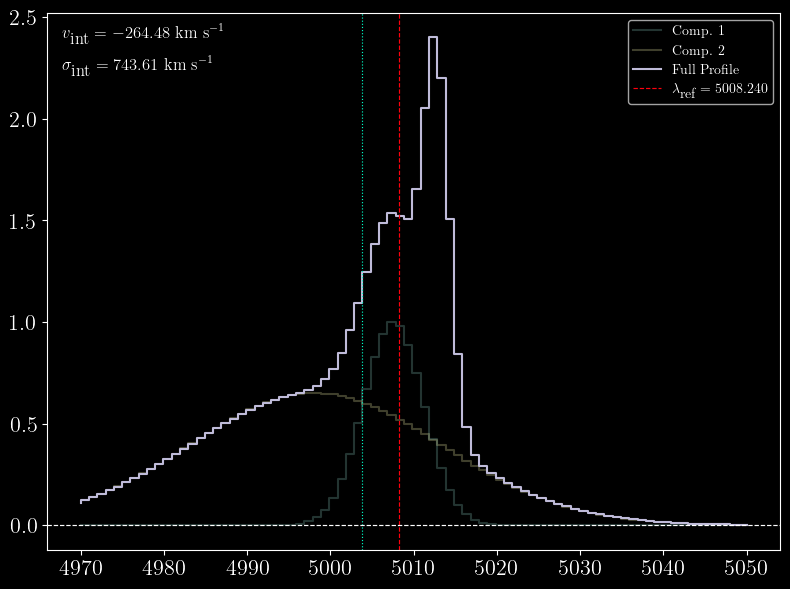

In [4]:
def find_nearest(array, value):
    """
    This function finds the nearest value in an array and returns the 
    closest value and the corresponding index.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

def gaussian(lam,center,amp,disp_kms,voff_kms,velscale=69.0):
    pix = np.arange(len(lam))
    interp_ftn = interp1d(lam,pix,kind="linear",bounds_error=False,fill_value=0.0)
    center_pix = interp_ftn(center)
    disp_pix = disp_kms/velscale
    voff_pix = voff_kms/velscale
#     print(center_pix,disp_pix,voff_pix)
    return amp*np.exp(-0.5*(pix-center_pix-voff_pix)**2/disp_pix**2) 

def velocity_moments(g):
    c = 299792.458 # speed of light (km/s)
    f = g/np.sum(g)# normalized profile
    v = (lam-center)/center*c# line-centered velocities
    vint = np.trapz(v*f)/np.trapz(f)# integrated velocity
    dint = np.sqrt(np.trapz(v**2*f)/np.trapz(f) - vint**2)
    return vint,dint

center = 5008.240
velscale = 69.0
wave = np.arange(4970,5051,1) #linear
g1 = gaussian(wave,center,1.0,250.0,0.0,velscale=velscale)
# g2 = gaussian(lam,center,0.45,450.0,-250.0,velscale=velscale)
g2 = gaussian(wave,center,0.65,1050.0,-650.0,velscale=velscale)
g3 = gaussian(wave,center,1.65,100.0,350.0,velscale=velscale)

g_linear  = g1+g2+g3

# Log rebin 
g, loglam, velscale = log_rebin((wave[0],wave[-1]), g_linear, oversample=1, velscale=None, flux=False)
lam = np.exp(loglam)
velscale = velscale[0]
print(velscale)

# Calculate combined velocity moments
vint, dint = velocity_moments(g)
print(vint,dint)

# Plot
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
fontsize=16

ax1.step(lam,g1,alpha=0.25,label=r"$\textrm{Comp. 1}$")
ax1.step(lam,g2,alpha=0.25,label=r"$\textrm{Comp. 2}$")
ax1.step(lam,g,label=r"$\textrm{Full Profile}$")
ax1.axvline(5008.240,linewidth=0.85,linestyle="--",color="xkcd:bright red",label=r"$\lambda_\textrm{ref}=%0.3f$" % center)
c = 299792.458 # speed of light (km/s)
ax1.axvline(vint*center/c+center,linewidth=0.85,linestyle=":",color="xkcd:bright teal",)


ax1.annotate(r"$v_\textrm{int}=%0.2f~\textrm{km s}^{-1}$" % vint, xy=(0.02, 0.98),  xycoords='axes fraction',
            xytext=(0.02, 0.98), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=fontsize-4,
            )
ax1.annotate(r"$\sigma_\textrm{int}=%0.2f~\textrm{km s}^{-1}$" % dint, xy=(0.02, 0.92),  xycoords='axes fraction',
            xytext=(0.02, 0.92), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=fontsize-4,
            )

ax1.axhline(0.0,linewidth=0.85,linestyle="--",color="xkcd:white")
ax1.set_xlabel(r"",fontsize=fontsize)
ax1.set_ylabel(r"",fontsize=fontsize)
ax1.set_title(r"",fontsize=fontsize)
ax1.tick_params(axis='both', labelsize=fontsize)
ax1.legend()

plt.tight_layout()

5003.839956491102
0.9456934462540136
15.507916348285887


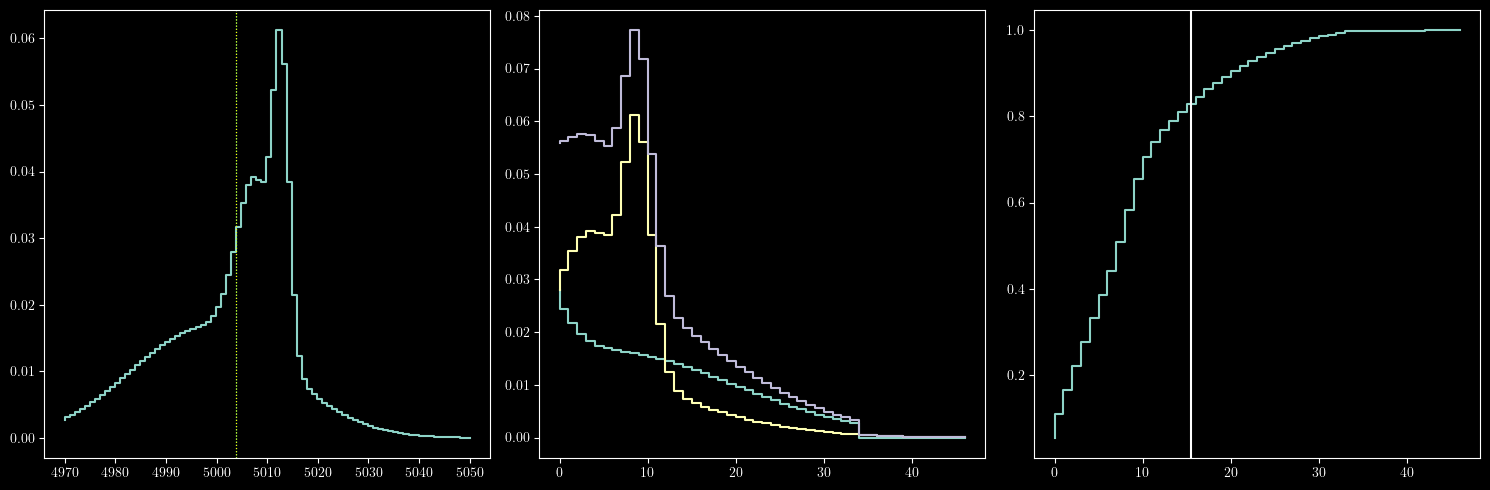

In [5]:
# normalize the emission line 
l = g/np.sum(g)
# calculate the central velocity
vc, pc = find_nearest((lam-center)/center*c,vint)
print(lam[pc])
#
v1, v2 = l[0:pc+1][::-1],l[pc:]
# l1, l2 = lam[0:pc+1],lam[pc:]
# Make arrays same length
arrays = [v1, v2]
if len(v1)>len(v2):
    v2 = np.concatenate([v2,np.zeros(len(v1)-len(v2))])
elif len(v2)>len(v1):
    v1 = np.concatenate([v1,np.zeros(len(v2)-len(v1))])

# Plot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
fontsize=16
ax1.step(lam,l)
ax1.axvline(vint*center/c+center,linewidth=0.85,linestyle=":",color="xkcd:bright teal",)
ax1.axvline(vc*center/c+center,linewidth=0.85,linestyle=":",color="xkcd:bright yellow",)
# 
ax2.step(range(len(v1)),v1)
ax2.step(range(len(v2)),v2)
ax2.step(range(len(v2)),v1+v2)
#
# CDF
cdf = np.cumsum(v1+v2)/np.sum(v1+v2)
ax3.step(range(len(v2)),cdf)
print(cdf.max()-cdf.min())
width_pix=np.interp(0.80,cdf,np.arange(len(cdf))+1)
print(width_pix)
ax3.axvline(width_pix,)

plt.tight_layout()

In [6]:
width_pix*2*velscale

1855.9910722716552

In [7]:
def integrate_peak3a(y, x, xlower, xupper):
    limits = np.array([xlower, xupper])
    indices = np.searchsorted(x, limits)
    indices = np.stack((indices - 1, indices), axis=0)
    xi = x[indices]
    yi = y[indices]
    yn = yi[0] + np.diff(yi, axis=0) * (limits - xi[0]) / np.diff(xi, axis=0)

    indices = indices[[1, 0], [0, 1]]
    s = slice(indices[0], indices[1] + 1)
    return np.trapz(np.r_[yn[0, 0], y[s], yn[0, 1]], np.r_[xlower, x[s], xupper])

low_lam, upp_lam = lam[pc]-(width_pix*velscale)*lam[pc]/c,lam[pc]+(width_pix*velscale)*lam[pc]/c
print(low_lam,upp_lam)
f80 = integrate_peak3a(g,lam,low_lam,upp_lam)
f = np.trapz(g,lam)
print(f,f80,f80/f)

4988.350770491761 5019.329142490444
39.13760373843827 31.55539150530815 0.8062678470607695


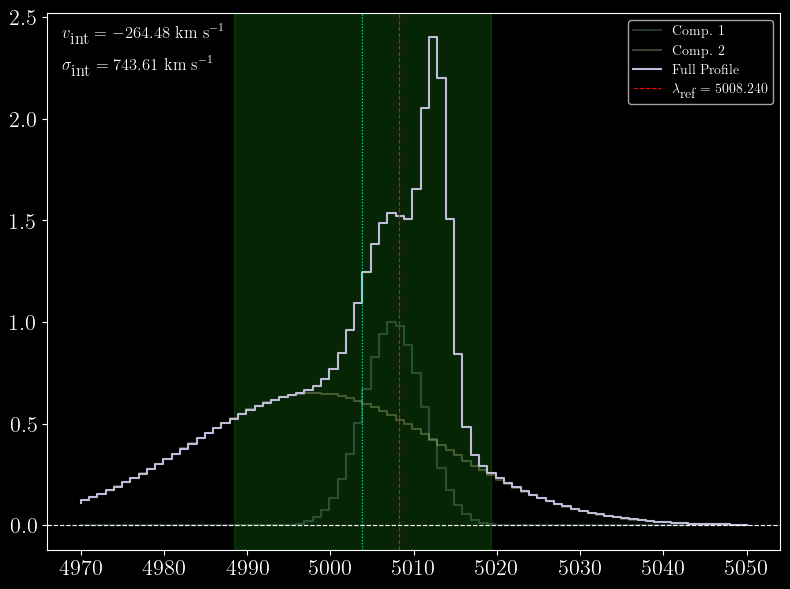

In [8]:
# Plot
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
fontsize=16

ax1.step(lam,g1,alpha=0.25,label=r"$\textrm{Comp. 1}$")
ax1.step(lam,g2,alpha=0.25,label=r"$\textrm{Comp. 2}$")
ax1.step(lam,g,label=r"$\textrm{Full Profile}$")
ax1.axvline(5008.240,linewidth=0.85,linestyle="--",color="xkcd:bright red",label=r"$\lambda_\textrm{ref}=%0.3f$" % center)
c = 299792.458 # speed of light (km/s)
ax1.axvline(vint*center/c+center,linewidth=0.85,linestyle=":",color="xkcd:bright teal",)


ax1.annotate(r"$v_\textrm{int}=%0.2f~\textrm{km s}^{-1}$" % vint, xy=(0.02, 0.98),  xycoords='axes fraction',
            xytext=(0.02, 0.98), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=fontsize-4,
            )
ax1.annotate(r"$\sigma_\textrm{int}=%0.2f~\textrm{km s}^{-1}$" % dint, xy=(0.02, 0.92),  xycoords='axes fraction',
            xytext=(0.02, 0.92), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=fontsize-4,
            )

ax1.axvspan(low_lam,upp_lam,color="xkcd:radioactive green",alpha=0.15)

ax1.axhline(0.0,linewidth=0.85,linestyle="--",color="xkcd:white")
ax1.set_xlabel(r"",fontsize=fontsize)
ax1.set_ylabel(r"",fontsize=fontsize)
ax1.set_title(r"",fontsize=fontsize)
ax1.tick_params(axis='both', labelsize=fontsize)
ax1.legend()

plt.tight_layout()


## Brute Force $W80$

Sample the distribution using the emission line profile (pdf) and calculate percentiles.

[-2289.28020044 -2229.89110808 -2170.49016018 -2111.07735435
 -2051.65268824 -1992.21615947 -1932.76776569 -1873.30750451
 -1813.83537358 -1754.35137051 -1694.85549295 -1635.34773852
 -1575.82810486 -1516.29658958 -1456.75319031 -1397.19790469
 -1337.63073035 -1278.0516649  -1218.46070598 -1158.85785121
 -1099.24309821 -1039.61644462  -979.97788805  -920.32742613
  -860.66505648  -800.99077672  -741.30458449  -681.60647739
  -621.89645306  -562.17450911  -502.44064316  -442.69485283
  -382.93713575  -323.16748953  -263.38591179  -203.59240014
  -143.78695221   -83.96956562   -24.14023798    35.7010331
    95.55425      155.41941509   215.29653078   275.18559944
   335.08662346   394.99960522   454.92454712   514.86145154
   574.81032086   634.77115749   694.7439638    754.72874218
   814.72549503   874.73422474   934.75493369   994.78762429
  1054.83229891  1114.88895995  1174.95760981  1235.03825088
  1295.13088555  1355.23551622  1415.35214527  1475.48077512
  1535.62140814  1595.774

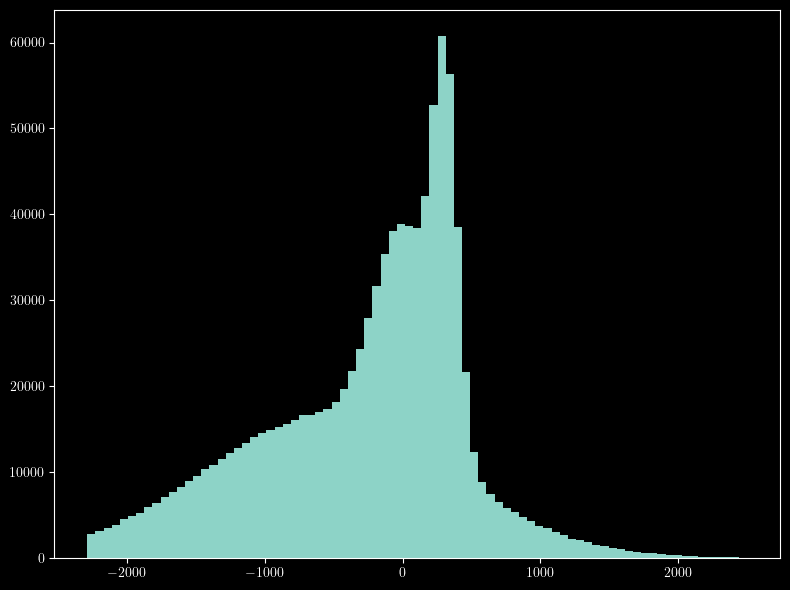

In [9]:
# Brute force
v = (lam-center)/center*c
print(v)
r = np.random.choice(v,p=l,size=1000000)

p = np.percentile(r,[10,90])
print(p)
print(np.sum(np.abs(p)))
# Plot
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
fontsize=16

ax1.hist(r,bins=len(v))

plt.tight_layout()

## Direct CDF

Infer the velocities from the CDF using interpolation


1852.6990140220068


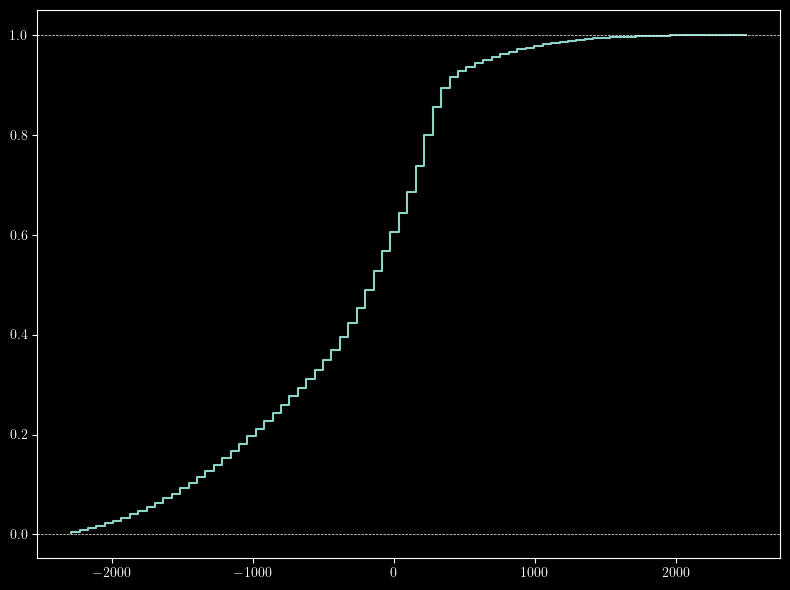

In [19]:
cdf = np.cumsum(g/np.sum(g))
v   = (lam-center)/center*c
# Plot
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
fontsize=16

ax1.step(v,cdf)
ax1.axhline(0.0,color="xkcd:white",linestyle="--",linewidth=0.5)
ax1.axhline(1.0,color="xkcd:white",linestyle="--",linewidth=0.5)

w80 = np.interp(0.91,cdf,v) - np.interp(0.10,cdf,v)
print(w80)

plt.tight_layout()